# Analyse the saliencies for PLA2 Dataset

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import os

import sys 
sys.path.append('../vespag')

from parse.vep_scores import load_vespag_scores_from_folder
from src.plotting import *
from src.amino_acid_groups import AA_GROUPS
from src.constants import GEMME_ALPHABET
from src.utils import *

## Data Loading and Enrichment

**Saliencies**

Due to data volume, I can't load everything at once. Each of the 524 sequences has a saliency map with the shape of (sequence length x 20 x 2560)... 
But at the moment, I am interested in comparing different types of correlations anyhow for which I can preprocess the saliencies directly (e.g. takking the average of the saliencies per wildtype). 
Hence, I will do these kind of preprocessing diretly after loading... 

In [3]:
wildtype_dimension = 0
mutant_dimension = 1
embeddings_dimension = 2

In [4]:
saliency_folder = '/mnt/f/nicole/pla2_saliency'

# load each numpy object in the saliency folder 
saliency_scores = {}
for file in tqdm(os.listdir(saliency_folder), unit='file', desc="Loading saliencies"):
    if file.endswith('.npy'):
        id = file.split('.npy')[0]
        saliency = np.load(os.path.join(saliency_folder, file))
        # reduce the saliency to the average per wiltype 
        saliency = saliency.mean(axis=(embeddings_dimension))
        saliency_scores[id] = saliency

Loading saliencies: 100%|██████████| 525/525 [11:49<00:00,  1.35s/file]


### Plot the Mean and SEM of the Salienciy for each Embedding Dimension over all Sequences in the PLA2 Dataset

In [13]:
saliency_folder = '/mnt/f/nicole/pla2_saliency'

mean_array = np.zeros((2560,)) 

sem_array = np.zeros((2560,))
files = [file for file in os.listdir(saliency_folder) if file.endswith('.npy')]

# # load each numpy object in the saliency folder 
# mean_saliency_per_dim_dict = {}
for file in tqdm(files, unit='file', desc="Loading saliencies"):
    id = file.split('.npy')[0]
    saliency = np.load(os.path.join(saliency_folder, file))
    # reduce the saliency to the average per embedding dimension 
    mean_saliency_per_dim = saliency.mean(axis=(wildtype_dimension, mutant_dimension)) # (2560,)

    # calculate the sem of the saliency
    sem_saliency_per_dim = np.std(saliency, axis=(wildtype_dimension, mutant_dimension)) / np.sqrt(saliency.shape[wildtype_dimension] * saliency.shape[mutant_dimension])
    #mean_saliency_per_dim_dict[id] = saliency
    mean_array += mean_saliency_per_dim
    sem_array += sem_saliency_per_dim

mean_array /= len(files)
sem_array /= len(files)


Loading saliencies: 100%|██████████| 524/524 [12:02<00:00,  1.38s/file]


In [20]:
#mean_array.where(mean_array > 0.14)
mean_array[mean_array > 0.14]

array([0.15371189, 0.18044181, 0.15533989, 0.16132524, 0.14978967,
       0.14075403, 0.1644217 , 0.16752706, 0.15742625])

In [25]:
# get thi indices of the embedding dimensio for which the mean saliency is greater than 0.14
indices = np.where(mean_array >= 0.14)[0]
indices

array([   4,  716, 1116, 1512, 1535, 2282, 2327, 2482, 2527])

In [32]:
# what is 0.95 quantile of the mean saliency per embedding dimension
np.quantile(mean_array, 0.99)

0.12083627676457762

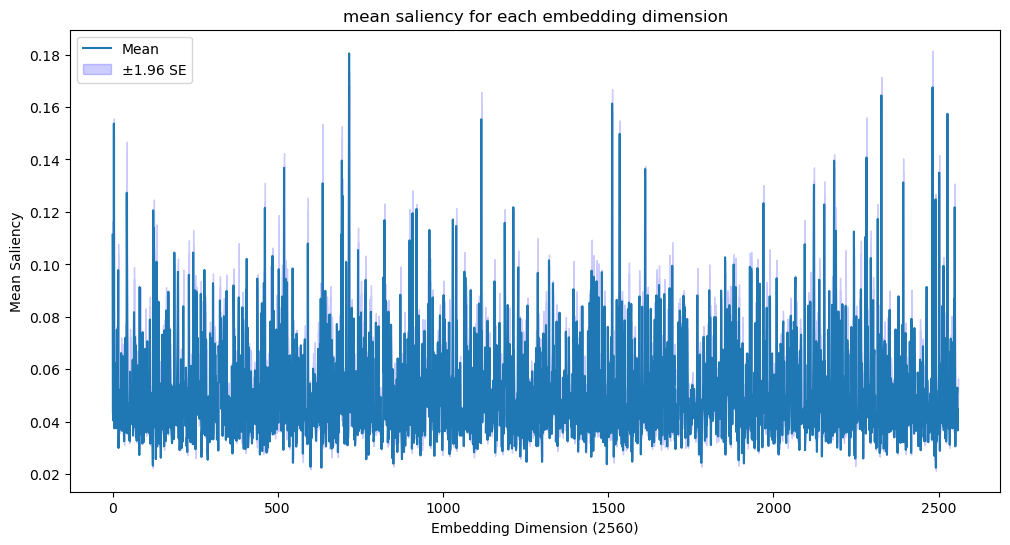

In [21]:
# plot the mean saliency for each embedding dimension
plt.figure(figsize=(12, 6))
plt.plot(mean_array, label="Mean")
plt.fill_between(
    np.arange(len(mean_array)),
    mean_saliency_per_dim - 1.96 * sem_array,
    mean_saliency_per_dim + 1.96 * sem_array,
    color="blue",
    alpha=0.2,
    label="±1.96 SE"
)

plt.xlabel("Embedding Dimension (2560)")
plt.ylabel("Mean Saliency")
plt.legend()
plt.title("mean saliency for each embedding dimension")
plt.show()

In [7]:
fasta_file = '../data/20231031_PLA2.fasta'

# parse the fasta file
sequences = {}
with open(fasta_file) as f:
    lines = f.readlines()
    for i in range(0, len(lines)):
        sequence = lines[i].strip()
        if sequence[0] == '>':
            id = sequence[1:]
        else:
            sequences[id] = sequence

# show the first two entries of the dictionary
[{k: sequences[k] for k in list(sequences)[:2]}]

[{'P00622_caudoxin_Bitis_caudalis': 'NLIQFGNMISAMTGKSSLAYASYGCYCGWGGKGQPKDDTDRCCFVHDCCYGKADKCSPKMILYSYKFHNGNIVCGDKNACKKKVCECDRVAAICFAASKHSYNKNLWRYPSSKCTGTAEKC',
  'DQ090656_1_Daboia_siamensis': 'NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFVHDCCYARVKGCNPKLVEYSYGYRTGKIVCENYNRCKRAVCECDRVAAICLGQNVNTYNKGYMFLSSYYCRQKSEQC'}]

VespaG

In [28]:
# load all the vespag scores for the pla2 dataset 
vespag_folder = '/mnt/f/nicole/pla2_vespag'
vespag_scores = load_vespag_scores_from_folder(vespag_folder)   
vespag_scores

Loading VespaG scores: 100%|██████████| 524/524 [00:10<00:00, 50.59file/s]


,residue,mutation,vespag,id
0,N1,N1A,-2.552438,AY355170_1_sistruxin_B_Sistrurus_tergeminus
1,N1,N1Y,-3.675682,AY355170_1_sistruxin_B_Sistrurus_tergeminus
2,N1,N1W,-4.004534,AY355170_1_sistruxin_B_Sistrurus_tergeminus
3,N1,N1V,-3.488040,AY355170_1_sistruxin_B_Sistrurus_tergeminus
4,N1,N1T,-2.369666,AY355170_1_sistruxin_B_Sistrurus_tergeminus
...,...,...,...,...
1222094,C122,C122D,-4.730935,EU369742_1_Sistrurus_catenatus
1222095,C122,C122A,-3.605922,EU369742_1_Sistrurus_catenatus
1222096,C122,C122W,-5.072160,EU369742_1_Sistrurus_catenatus
1222097,C122,C122L,-4.458437,EU369742_1_Sistrurus_catenatus


In [29]:
# invert the vespag score to get the mutation effect
vespag_scores['mutation_effect'] = - vespag_scores['vespag']
# extract residue_index 
vespag_scores['residue_index'] = vespag_scores['residue'].str[1:].astype(int)
# extract the wildtype residue
vespag_scores['wildtype'] = vespag_scores['residue'].str[0]
# extract the mutant residue
vespag_scores['mutant'] = vespag_scores['mutation'].str[-1]
# add the amino acid annotation for each wildtype
aa_groups = list(AA_GROUPS.keys())
for aa_group in aa_groups:
    vespag_scores[f'wildtype_{aa_group}'] = vespag_scores['wildtype'].apply(lambda x: AA_GROUPS[aa_group][x])
    vespag_scores[f'mutant_{aa_group}'] = vespag_scores['mutant'].apply(lambda x: AA_GROUPS[aa_group][x])
    vespag_scores[f'change_{aa_group}'] = vespag_scores[f'wildtype_{aa_group}'] != vespag_scores[f'mutant_{aa_group}']
vespag_scores.head()

,residue,mutation,vespag,id,mutation_effect,residue_index,wildtype,mutant,wildtype_hydropathy_classes,mutant_hydropathy_classes,...,change_physicochemical_classes,wildtype_charge_classes,mutant_charge_classes,change_charge_classes,wildtype_polarity_classes,mutant_polarity_classes,change_polarity_classes,wildtype_hydrogen_donor_acceptor_classes,mutant_hydrogen_donor_acceptor_classes,change_hydrogen_donor_acceptor_classes
0,N1,N1A,-2.552438,AY355170_1_sistruxin_B_Sistrurus_tergeminus,2.552438,1,N,A,hydrophilic,hydrophobic,...,True,uncharged,uncharged,False,polar,nonpolar,True,donor and acceptor,none,True
1,N1,N1Y,-3.675682,AY355170_1_sistruxin_B_Sistrurus_tergeminus,3.675682,1,N,Y,hydrophilic,neutral,...,True,uncharged,uncharged,False,polar,polar,False,donor and acceptor,donor and acceptor,False
2,N1,N1W,-4.004534,AY355170_1_sistruxin_B_Sistrurus_tergeminus,4.004534,1,N,W,hydrophilic,hydrophobic,...,True,uncharged,uncharged,False,polar,nonpolar,True,donor and acceptor,donor,True
3,N1,N1V,-3.488040,AY355170_1_sistruxin_B_Sistrurus_tergeminus,3.488040,1,N,V,hydrophilic,hydrophobic,...,True,uncharged,uncharged,False,polar,nonpolar,True,donor and acceptor,none,True
4,N1,N1T,-2.369666,AY355170_1_sistruxin_B_Sistrurus_tergeminus,2.369666,1,N,T,hydrophilic,neutral,...,True,uncharged,uncharged,False,polar,polar,False,donor and acceptor,donor and acceptor,False


In [22]:
saliency_scores_df = pd.DataFrame()

# Initialize tqdm for progress tracking
for id, average_saliency in tqdm(saliency_scores.items(), desc="Processing Saliency Scores"):
    id = id.split('_saliency')[0]
    # Get the sequence for the current ID
    sequence = sequences[id]

    for residue_index, (wildtype, saliency) in enumerate(zip(sequence, average_saliency), start=1):
        # Convert saliency into DataFrame
        saliency_df = pd.DataFrame(saliency, columns=['saliency'])
        saliency_df['mutant'] = list(GEMME_ALPHABET)
        saliency_df['residue_index'] = residue_index
        saliency_df['wildtype'] = wildtype
        saliency_df['id'] = id
        saliency_scores_df = pd.concat([saliency_scores_df, saliency_df], ignore_index=True)
saliency_scores_df

Processing Saliency Scores:   0%|          | 0/524 [00:00<?, ?it/s]

Processing Saliency Scores: 100%|██████████| 524/524 [15:34<00:00,  1.78s/it]


,saliency,mutant,residue_index,wildtype,id
0,0.053740,A,1,H,AB072173_1_Protobothrops_flavoviridis
1,0.050604,C,1,H,AB072173_1_Protobothrops_flavoviridis
2,0.054081,D,1,H,AB072173_1_Protobothrops_flavoviridis
3,0.054865,E,1,H,AB072173_1_Protobothrops_flavoviridis
4,0.063064,F,1,H,AB072173_1_Protobothrops_flavoviridis
...,...,...,...,...,...
1286415,0.058622,S,122,C,XM_039367474_1_Crotalus_tigris
1286416,0.059509,T,122,C,XM_039367474_1_Crotalus_tigris
1286417,0.071970,V,122,C,XM_039367474_1_Crotalus_tigris
1286418,0.070535,W,122,C,XM_039367474_1_Crotalus_tigris


In [ ]:
assert saliency_scores_df[saliency_scores_df.mutant == saliency_scores_df.wildtype].saliency.sum() == 0

array([0.])

In [26]:
saliency_scores_df.to_parquet('pla2_avg_saliency_per_mutation.parquet')


In [31]:
# merge the vespag scores with the average saliency
mutation_effect_avg_saliency = saliency_scores_df.merge(vespag_scores, on=['residue_index', 'mutant'], how='inner')
mutation_effect_avg_saliency.head()

: 

## Aggregation over the entire Sequence 

In [ ]:
plot_mutation_saliency_over_sequence(mutation_effect_avg_saliency, sequence)

## Investigate H48

In [ ]:
# out of curiosity: look into the saliency for H48 -> H47 due to common numbering scheme
residue_index_one_index = 47
residue_index_zero_index = residue_index_one_index - 1
assert saliency_map[residue_index_zero_index][GEMME_ALPHABET.index('H')].all() == 0
assert sequence[residue_index_zero_index] == 'H'
plot_residue_saliency_3d(saliency_map, residue_index_zero_index, title="3D Saliency Map for H48")

In [ ]:
plot_residue_saliency_2d(saliency_map, residue_index_zero_index, title="2D Saliency Map for H48")

## Average Saliency of each Embedding Dimension

In [ ]:
plot_mean_saliency_for_residue(saliency_map, residue_index_zero_index, title="Mean and SE of Saliency for each Embedding Dimension for H48")

In [ ]:
plot_mean_saliency_for_sequence(saliency_map, title="Mean and SE of Saliency for each Embedding Dimension for the Sequence")

In [ ]:
saliency_map.shape

In [ ]:
saliency_slice = saliency_map[residue_index_zero_index]
# Number of top saliencies to retrieve
top_n = 4

# Flatten the 2D array into a 1D array
flat_indices = np.argsort(saliency_slice.ravel())[-top_n:][::-1]  # Get indices of top N values

# Convert flat indices back to 2D indices
mutant_indices, embedding_dims = np.unravel_index(flat_indices, saliency_slice.shape)

# Get top saliency values
top_saliency_values = saliency_slice[mutant_indices, embedding_dims]

# Print results
print(f"Top {top_n} highest saliencies for residue H48:")
for i in range(top_n):
    print(f"{i + 1}. Mutant {mutant_indices[i]}, Embedding Dimension {embedding_dims[i]} - Saliency: {top_saliency_values[i]:.4f}")

In [ ]:
highest_scoring_saliencies(saliency_map, residue_index_zero_index, n=5)

## Mutation Effect vs. Mutant colored by AA Properties

In [ ]:
plot_mutation_effect_for_residue(mutation_effect_avg_saliency, residue_index_one_index, title="Mutation Effect for H48")
plot_mutation_effect_for_residue(mutation_effect_avg_saliency, residue_index_one_index, title="Mutation Effect for H48", color_by='saliency')
plot_mutation_effect_for_residue(mutation_effect_avg_saliency, residue_index_one_index, title="Mutation Effect for H48", color_by='mutant_chemical_classes')

In [ ]:
options = ['hydropathy_classes', 'volume_classes', 'chemical_classes', 'physicochemical_classes', 'charge_classes', 'polarity_classes', 'hydrogen_donor_acceptor_classes']
options = [f'mutant_{option}' for option in options] + [f'change_{option}' for option in options] + [f'wildtype_{option}' for option in options]
for option in options:
    print(option)
    plot_mutation_effect_for_residue(mutation_effect_avg_saliency, residue_index_one_index, title=f"Mutation Effect for H48 ({option})", color_by=option)

## Mutation Effect vs. Saliency colored by AA Properties 

In [20]:
from src.plotting import plot_interactive_mutant_effect_vs_saliency

In [ ]:
plot_interactive_mutant_effect_vs_saliency(mutation_effect_avg_saliency, title="Mutation Effect vs Average Saliency")

for option in options + ['mutant', 'wildtype']:
    plot_interactive_mutant_effect_vs_saliency(mutation_effect_avg_saliency, title=f"Mutation Effect vs Average Saliency ({option})", color_by=option)

## Parallel Coordinates Plot

In [22]:
from src.plotting import plot_parallel_coordinates

In [ ]:
plot_parallel_coordinates(mutation_effect_avg_saliency, columns_to_use=[
    'mutation_effect',
    'avg_saliency',
    'mutant_hydropathy_classes',
    'mutant_volume_classes',
    'mutant_chemical_classes',
    'mutant_physicochemical_classes',
    'mutant_charge_classes',
    'mutant_polarity_classes',
    'mutant_hydrogen_donor_acceptor_classes',
    'mutant'
    ],
    title="Parallel Coordinates Plot using aa properties of the Mutant"
)

In [ ]:
plot_parallel_coordinates(mutation_effect_avg_saliency, columns_to_use=[
    'mutation_effect',
    'avg_saliency',
    'mutant_hydropathy_classes',
    'mutant_volume_classes',
    'mutant_chemical_classes',
    'mutant_physicochemical_classes',
    'mutant_charge_classes',
    'mutant_polarity_classes',
    'mutant_hydrogen_donor_acceptor_classes',
    ],
    title="Parallel Coordinates Plot using aa properties of the Mutant"
)

In [ ]:
plot_parallel_coordinates(mutation_effect_avg_saliency, columns_to_use=[
    'mutation_effect',
    'avg_saliency',
    'wildtype_hydropathy_classes',
    'wildtype_volume_classes',
    'wildtype_chemical_classes',
    'wildtype_physicochemical_classes',
    'wildtype_charge_classes',
    'wildtype_polarity_classes',
    'wildtype_hydrogen_donor_acceptor_classes',
    'wildtype'
    ],
    title="Parallel Coordinates Plot using aa properties of the Wildtype"
)

In [ ]:
plot_parallel_coordinates(mutation_effect_avg_saliency, columns_to_use=[
    'mutation_effect',
    'avg_saliency',
    'wildtype_hydropathy_classes',
    'wildtype_volume_classes',
    'wildtype_chemical_classes',
    'wildtype_physicochemical_classes',
    'wildtype_charge_classes',
    'wildtype_polarity_classes',
    'wildtype_hydrogen_donor_acceptor_classes',
    ],
    title="Parallel Coordinates Plot using aa properties of the Wildtype"
)

In [ ]:
plot_parallel_coordinates(mutation_effect_avg_saliency, columns_to_use=[
    'mutation_effect',
    'avg_saliency',
    'change_hydropathy_classes',
    'change_volume_classes',
    'change_chemical_classes',
    'change_physicochemical_classes',
    'change_charge_classes',
    'change_polarity_classes',
    'change_hydrogen_donor_acceptor_classes'
    ],
    title="Parallel Coordinates Plot using aa properties of the Wildtype"
)

## Boxplots and Violinplots

In [ ]:
mutation_effect_avg_saliency[['mutation_effect', 'wildtype']].groupby('wildtype')

In [ ]:
# mutation effect
plot_distribution(mutation_effect_avg_saliency, data_column='mutation_effect', label_column='mutant', title="Distribution of Mutation Effect by Mutant")
plot_distribution(mutation_effect_avg_saliency, data_column='mutation_effect', label_column='wildtype', title="Distribution of Mutation Effect by Wildtype")
# plot_distribution(mutation_effect_avg_saliency, data_column='mutation_effect', label_column='wildtype', title="Distribution of Mutation Effect by Wildtype (colored by Wildtype)", color_by='wildtype')
plot_distribution(mutation_effect_avg_saliency, data_column='mutation_effect', label_column='wildtype', title="Distribution of Mutation Effect by Wildtype (colored by physiochemical)", color_by='wildtype_physicochemical_classes')
plot_distribution(mutation_effect_avg_saliency, data_column='mutation_effect', label_column='wildtype', title="Distribution of Mutation Effect by Wildtype (colored by hydrogen donor/ acceptor)", color_by='wildtype_hydrogen_donor_acceptor_classes')
plot_distribution(mutation_effect_avg_saliency, data_column='mutation_effect', label_column='wildtype', title="Distribution of Mutation Effect by Wildtype (colored by chemical)", color_by='wildtype_chemical_classes')

# saliency 
plot_distribution(mutation_effect_avg_saliency, data_column='avg_saliency', label_column='mutant', title="Distribution of Average Saliency by Mutant")
plot_distribution(mutation_effect_avg_saliency, data_column='avg_saliency', label_column='wildtype', title="Distribution of Average Saliency by Wildtype")
# plot_distribution(mutation_effect_avg_saliency, data_column='avg_saliency', label_column='wildtype', title="Distribution of Average Saliency by Wildtype (colored by Wildtype)", color_by='wildtype')
plot_distribution(mutation_effect_avg_saliency, data_column='avg_saliency', label_column='wildtype', title="Distribution of Average Saliency by Wildtype (colored by physiochemical)", color_by='wildtype_physicochemical_classes')
plot_distribution(mutation_effect_avg_saliency, data_column='avg_saliency', label_column='wildtype', title="Distribution of Average Saliency by Wildtype (colored by hydrogen donor/ acceptor)", color_by='wildtype_hydrogen_donor_acceptor_classes')
plot_distribution(mutation_effect_avg_saliency, data_column='avg_saliency', label_column='wildtype', title="Distribution of Average Saliency by Wildtype (colored by chemical)", color_by='wildtype_chemical_classes')
